# Endprojekt GIS Analyse - Location Analysis for a new Stadium in Graz

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Geospatial
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Polygon
import osmnx as ox
import networkx as nx

# Raster processing
import os
import pyproj
# optinal code fix with PROJ_LIB if pyproj doesnt work properly
os.environ["PROJ_LIB"] = pyproj.datadir.get_data_dir()

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import CRS
from rasterio.features import shapes
from shapely.geometry import shape


Data Preparation
===============================================================================     

Getting district boundaries of Graz (District boundaries (Overpass Turbo (n.d.). Overpass API web interface. https://overpass-turbo.eu/ (Accessed December 2, 2025))) <br>
and <br>
population statistic (Stadt Graz (2025). Zahlen + Fakten: Bevölkerung, Bezirke, Wirtschaft, Geografie. https://www.graz.at/cms/beitrag/10034466/7772565/Zahlen_Fakten_Bevoelkerung_Bezirke_Wirtschaft.html (Accessed December 2, 2025))

In [ ]:
#loading GeoJson Districts of Graz
gdf_districts = gpd.read_file("data/district_graz.geojson")
gdf_districts = gdf_districts[["name", "geometry"]].copy() #extract the columns needed

Getting hard exklusion layers from OpenStreetMap via OSMnx, set the CRS to 32633 (UTM zone 33N) and buffer some of them:<br>
- water bodies buffer (10m)<br>
- parks/green areas <br>
- transport infrastructure <br>
- buildings (buffer 250m for hospitals, kingardens, cemeteries)

In [3]:
PLACE_NAME:str = "Graz, Austria"
#TARGET_CRS = "EPSG:32633"  # UTM zone 33N

In [4]:
tags_water = {
    "natural": ["water"],
    "waterway": ["river", "stream", "canal", "ditch"],
    "landuse": ["reservoir"],
    "water": ["lake", "river", "pond", "basin"]
}
gdf_water = ox.features_from_place(
    PLACE_NAME,
    tags=tags_water
)
gdf_water = gdf_water[["geometry"]].copy()
gdf_water["category"] = "water"

# Reproject
gdf_water = gdf_water.to_crs(epsg=32633)

# 20 meter buffer
gdf_water_Buffer20m = gdf_water.copy()
gdf_water_Buffer20m["geometry"] = gdf_water_Buffer20m.buffer(20)
gdf_water_Buffer20m.head()

geometry category
element  id                                                                 
relation 1306807  POLYGON ((532493.308 5213424.458, 532492.762 5...    water
         2325656  POLYGON ((536884.355 5207621.79, 536885.105 52...    water
         3403202  POLYGON ((536189.617 5210881.951, 536188.455 5...    water
         3562966  POLYGON ((533575.587 5209754.372, 533574.904 5...    water
         3587716  POLYGON ((535239.727 5206817.913, 535241.479 5...    water

In [5]:
#Excklusion Parks
tags_parks = {
    "leisure": [
        "park", "garden", "playground", "recreation_ground"
    ],
    "boundary": [
        "protected_area"
    ]
}
gdf_parks = ox.features_from_place(
    PLACE_NAME,
    tags=tags_parks
)

gdf_parks = gdf_parks[["geometry"]].copy()
gdf_parks["category"] = "green areas"

# Reproject
gdf_parks = gdf_parks.to_crs(epsg=32633)

# 20 meter buffer
gdf_parks_Buffer20m = gdf_parks.copy()
gdf_parks_Buffer20m["geometry"] = gdf_parks_Buffer20m.buffer(20)
gdf_parks_Buffer20m.head(5)

geometry  \
element id                                                              
node    859421763   POLYGON ((529258.583 5215245.914, 529258.487 5...   
        940994980   POLYGON ((532495.494 5215082.215, 532495.398 5...   
        1053837597  POLYGON ((534682.168 5213142.265, 534682.072 5...   
        1265834876  POLYGON ((532026.172 5209443.055, 532026.076 5...   
        1412653685  POLYGON ((532010.365 5216204.807, 532010.269 5...   

                       category  
element id                       
node    859421763   green areas  
        940994980   green areas  
        1053837597  green areas  
        1265834876  green areas  
        1412653685  green areas

In [6]:
#Exclusion Transport Areas
tags_transport = {
    "highway": [
        "motorway", "trunk", "primary", "secondary", "tertiary",
        "motorway_link", "trunk_link", "primary_link", "secondary_link"
    ],
    "railway": [
        "rail", "tram", "light_rail", "subway"
    ]
}

gdf_transport = ox.features_from_place(
    PLACE_NAME,
    tags=tags_transport
)

gdf_transport = gdf_transport[["geometry"]].copy()
gdf_transport["category"] = "transport infrastructure"

# Reproject
gdf_transport = gdf_transport.to_crs(epsg=32633)

# 20 meter buffer
gdf_transport_Buffer20m = gdf_transport.copy()
gdf_transport_Buffer20m["geometry"] = gdf_transport_Buffer20m.buffer(20)
gdf_transport_Buffer20m.head(20)

geometry  \
element id                                                           
way     3987860  POLYGON ((533449.684 5211136.395, 533465.333 5...   
        3991673  POLYGON ((533280.286 5213193.422, 533280.399 5...   
        3991674  POLYGON ((534340.711 5211868.999, 534341.198 5...   
        3992913  POLYGON ((533593.03 5212405.682, 533593 521240...   
        3992916  POLYGON ((536352.536 5209722.242, 536355.837 5...   
        3992920  POLYGON ((536223.209 5208898.865, 536215.025 5...   
        3992921  POLYGON ((537098.264 5209773.987, 537098.543 5...   
        3993614  POLYGON ((534692.734 5212269.011, 534695.215 5...   
        3993615  POLYGON ((535012.603 5212456.471, 535015.55 52...   
        3995445  POLYGON ((535250.201 5210298.075, 535251.198 5...   
        3997179  POLYGON ((533882.629 5212763.121, 533880.227 5...   
        3997181  POLYGON ((533526.762 5212817.099, 533526.869 5...   
        3997182  POLYGON ((533796.086 5212962.12, 533771.174 52...   
        3997183  POLYGON ((533059.821 5212644.213, 533060.055 5...   
        3997185  POLYGON ((532983.79 5212614.523, 532981.831 52...   
        3997187  POLYGON ((532404.634 5212619.653, 532402.702 5...   
        3997188  POLYGON ((530730.677 5209707.406, 530732.635 5...   
        3997189  POLYGON ((531384.022 5209762.696, 531382.568 5...   
        3997190  POLYGON ((533096.522 5208533.592, 533094.993 5...   
        3997191  POLYGON ((531379.256 5208939.667, 531380.633 5...   

                                 category  
element id                                 
way     3987860  transport infrastructure  
        3991673  transport infrastructure  
        3991674  transport infrastructure  
        3992913  transport infrastructure  
        3992916  transport infrastructure  
        3992920  transport infrastructure  
        3992921  transport infrastructure  
        3993614  transport infrastructure  
        3993615  transport infrastructure  
        3995445  transport infrastructure  
        3997179  transport infrastructure  
        3997181  transport infrastructure  
        3997182  transport infrastructure  
        3997183  transport infrastructure  
        3997185  transport infrastructure  
        3997187  transport infrastructure  
        3997188  transport infrastructure  
        3997189  transport infrastructure  
        3997190  transport infrastructure  
        3997191  transport infrastructure

In [7]:
#Exclusion Buildings
tags_buildings_hard = {
    "building": True
}

gdf_buildings = ox.features_from_place(
    PLACE_NAME,
    tags=tags_buildings_hard
)

gdf_buildings = gdf_buildings[["geometry"]].copy()
gdf_buildings["category"] = "buildings_hard"

# Reproject
gdf_buildings = gdf_buildings.to_crs(epsg=32633)
gdf_buildings_Buffer30m = gdf_buildings.copy()
gdf_buildings_Buffer30m["geometry"] = gdf_buildings_Buffer30m.buffer(30)
gdf_buildings_Buffer30m.head(5)

geometry  \
element id                                                              
node    278296607   POLYGON ((532743.99 5212987.937, 532743.846 52...   
        1083590320  POLYGON ((531854.409 5213308.019, 531854.264 5...   
        1188213884  POLYGON ((533232.322 5212779.72, 533232.177 52...   
        1446305820  POLYGON ((531810.911 5214585.035, 531810.767 5...   
        1485789259  POLYGON ((532044.902 5213725.416, 532044.757 5...   

                          category  
element id                          
node    278296607   buildings_hard  
        1083590320  buildings_hard  
        1188213884  buildings_hard  
        1446305820  buildings_hard  
        1485789259  buildings_hard

In [8]:
#Cemeteries with 250m Buffer
tags_cemetery = {
    "landuse": ["cemetery"],
    "amenity": ["grave_yard"]
}

gdf_cemetery = ox.features_from_place(
    PLACE_NAME,
    tags=tags_cemetery
)

gdf_cemetery = gdf_cemetery[["geometry"]].copy()
gdf_cemetery["category"] = "cemetery"

gdf_cemetery = gdf_cemetery.to_crs(epsg=32633)
gdf_cemetery.head(5)

geometry  \
element  id                                                              
node     1447016305                      POINT (535889.182 5209509.97)   
relation 1252339     POLYGON ((531967.661 5210631.508, 531988.86 52...   
         1252342     POLYGON ((532066.233 5210275.077, 532053.994 5...   
         2694625     MULTIPOLYGON (((531233.48 5218089.831, 531255....   
         17946151    POLYGON ((534965.319 5212317.125, 534995.58 52...   

                     category  
element  id                    
node     1447016305  cemetery  
relation 1252339     cemetery  
         1252342     cemetery  
         2694625     cemetery  
         17946151    cemetery

Merge to one geodataframe and dissolve to one geometry

In [9]:
gdf_exclusion_areas = pd.concat([
    gdf_water_Buffer20m,
    gdf_parks_Buffer20m,
    gdf_transport_Buffer20m,
    gdf_buildings_Buffer30m,
    gdf_cemetery,
], ignore_index=True)

In [10]:
gdf_exclusion_areas.head(5)

,geometry,category
0,"POLYGON ((532493.308 5213424.458, 532492.762 5...",water
1,"POLYGON ((536884.355 5207621.79, 536885.105 52...",water
2,"POLYGON ((536189.617 5210881.951, 536188.455 5...",water
3,"POLYGON ((533575.587 5209754.372, 533574.904 5...",water
4,"POLYGON ((535239.727 5206817.913, 535241.479 5...",water


In [11]:
gdf_exclusion_areas.geometry.geom_type.value_counts()


Polygon         70641
MultiPolygon        7
Point               1
Name: count, dtype: int64

In [12]:
gdf_exclusion_areas = gdf_exclusion_areas[
    gdf_exclusion_areas.geometry.geom_type != "Point"
]
gdf_exclusion_areas = gdf_exclusion_areas.explode(
    ignore_index=True
)
gdf_exclusion_areas.geometry.geom_type.value_counts()

Polygon    70668
Name: count, dtype: int64

Reprojecting DEM from WGS84 to UTM33N and calculate slope 

In [13]:
dem_in = "data/DEM30_Graz.tif"          # original DEM
dem_utm = "data/DEM30_Graz_utm33.tif"   # output DEM (UTM33N)

with rasterio.open(dem_in) as src:
    src_crs = src.crs if src.crs is not None else CRS.from_epsg(4326)
    dst_crs = CRS.from_epsg(32633)  # UTM Zone 33N

    transform, width, height = calculate_default_transform(
        src_crs, dst_crs, src.width, src.height, *src.bounds
    )

    profile = src.profile.copy()
    profile.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height,
        "nodata": src.nodata if src.nodata is not None else -9999
    })

    with rasterio.open(dem_utm, "w", **profile) as dst:
        dst_array = np.full((height, width), profile["nodata"], dtype=profile["dtype"])
        dst.write(dst_array, 1)

        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src_crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear,
            src_nodata=src.nodata,
            dst_nodata=profile["nodata"]
        )

In [14]:
dem_path = "data/DEM30_Graz_utm33.tif"
slope_path = "data/dem_slope.tif"

with rasterio.open(dem_path) as src:
    dem = src.read(1, masked=True).astype("float64")
    profile = src.profile.copy()
    transform = src.transform

xres = transform.a
yres = abs(transform.e)

dzdy, dzdx = np.gradient(dem.filled(np.nan), yres, xres)

slope_rad = np.arctan(np.sqrt(dzdx**2 + dzdy**2))
slope_deg = np.degrees(slope_rad)

nodata_out = -9999.0
slope_out = np.where(np.isnan(slope_deg), nodata_out, slope_deg).astype(np.float32)

profile.update(dtype=rasterio.float32, count=1, nodata=nodata_out)

with rasterio.open(slope_path, "w", **profile) as dst:
    dst.write(slope_out, 1)


Polygonize slope raster for areas with slope greater than threshold (e.g. 5 degrees)

In [15]:
slope_path = "data/dem_slope.tif"
out_path   = "data/slope_filtered.shp"

threshold   = 5.0     # Grad
min_area_m2 = 500.0   # Mindestfläche

with rasterio.open(slope_path) as src:
    slope = src.read(1)
    transform = src.transform
    crs = src.crs
    nodata = src.nodata

mask = slope > threshold
if nodata is not None:
    mask = mask & (slope != nodata)
mask = mask & np.isfinite(slope)

value_raster = mask.astype(np.uint8)

geoms = []
for geom, value in shapes(value_raster, mask=mask, transform=transform):
    if value == 1:
        geoms.append(shape(geom))

gdf_slope = gpd.GeoDataFrame(geometry=geoms, crs=crs)

gdf_slope["diss"] = 1
gdf_slope = gdf_slope.dissolve(by="diss")
gdf_slope = gdf_slope.explode(index_parts=False).reset_index(drop=True)

gdf_slope["area_m2"] = gdf_slope.area
gdf_slope = gdf_slope[gdf_slope["area_m2"] >= min_area_m2]

gdf_slope["slope_gt"] = threshold
gdf_slope = gdf_slope[["slope_gt", "area_m2", "geometry"]]
gdf_slope.to_file(out_path, driver="ESRI Shapefile")

print(f"{len(gdf_slope)} Polygone gespeichert in {out_path}")

4307 Polygone gespeichert in data/slope_filtered.shp


c:\Users\cleam\Documents\UNI\WS2025\Gat2\venv-gat2\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 166892829.33209983 of field area_m2 of feature 3466 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(


In [ ]:
graz = gdf_districts.copy()
steep = gpd.read_file("data/slope_filtered.shp")

if graz.crs != steep.crs:
    graz = graz.to_crs(steep.crs)

#fix potential geometry issues
graz["geometry"] = graz.geometry.buffer(0)
steep["geometry"] = steep.geometry.buffer(0)

#union all areas 
steep_union = steep.geometry.union_all()

#differnce
result = graz.copy()
result["geometry"] = result.geometry.difference(steep_union)

#remove empty geometries
result = result[result.geometry.notna() & ~result.is_empty]

result.to_file("data/graz_suitable_slope.shp", driver="ESRI Shapefile")



C:\Users\cleam\AppData\Local\Temp\ipykernel_19740\4066166847.py:21: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  result.to_file("data/graz_suitable_slope.shp", driver="ESRI Shapefile")
c:\Users\cleam\Documents\UNI\WS2025\Gat2\venv-gat2\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Größe in km2' to 'Größe in'
  ogr_write(
c:\Users\cleam\Documents\UNI\WS2025\Gat2\venv-gat2\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Einwohner pro km2' to 'Einwohne_1'
  ogr_write(


In [17]:
import geopandas as gpd

suitable = gpd.read_file("data/graz_suitable_slope.shp")
excluded = gdf_exclusion_areas.copy()

if suitable.crs != excluded.crs:
    excluded = excluded.to_crs(suitable.crs)

suitable["geometry"] = suitable.geometry.buffer(0)
excluded["geometry"] = excluded.geometry.buffer(0)

excluded_union = excluded.geometry.union_all()

suitable_area = suitable.copy()
suitable_area["geometry"] = suitable_area.geometry.difference(excluded_union)

suitable_area = suitable_area[suitable_area.geometry.notna() & ~suitable_area.is_empty].copy()

suitable_area = suitable_area.explode(index_parts=False).reset_index(drop=True)
suitable_area = suitable_area[suitable_area.geometry.notna() & ~suitable_area.is_empty].copy()

suitable_area["area_m2"] = suitable_area.area
suitable_area = suitable_area[suitable_area["area_m2"] >= 130000][["area_m2", "geometry"]]

suitable_area.to_file("data/graz_final_suitable_areas_slope.shp", driver="ESRI Shapefile")
print("ready:", len(suitable_area), "Polygons")

ready: 5 Polygons


C:\Users\cleam\AppData\Local\Temp\ipykernel_19740\1892264636.py:17: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  suitable_area = suitable_area[suitable_area.geometry.notna() & ~suitable_area.is_empty].copy()


In [18]:
print("Graz CRS:", graz.crs)
print("Steep CRS:", steep.crs)
slope_graz = gpd.read_file("data/graz_suitable_slope.shp")
print("Slope CRS:", slope_graz.crs)

Graz CRS: EPSG:32633
Steep CRS: EPSG:32633
Slope CRS: EPSG:32633


### Distance Calculation for nearest distances to relevant point and polygon layers

nearest distances to hospitals, cemetries, kindergardens, religious areas, and residential areas <br>
all distances are calculated in meters <br>
set your desired EPSG code (default: 32633) <br>
shorter distances are worse (higher distance values are better) <br>
(using function add_nearest_distances)

In [19]:
# get relevant point and polygon layers from OSM via osmnx
gdf_kindergarten = ox.features_from_place(PLACE_NAME, tags={"amenity": ["kindergarten"]})
gdf_hospital = ox.features_from_place(PLACE_NAME, tags={"amenity": ["hospital"]})
gdf_religious = ox.features_from_place(PLACE_NAME, tags={"amenity": ["place_of_worship"]})
gdf_residential = ox.features_from_place(PLACE_NAME, tags={"landuse": ["residential"]})[["geometry"]]

In [20]:
# function to convert geometries to points and set right crs
def only_points(gdf, category, epsg=32633):
    g = gdf[["geometry"]].to_crs(epsg).assign(category=category)
    g["geometry"] = g.geometry.representative_point().where(g.geom_type != "Point", g.geometry)
    return g[["category", "geometry"]]

In [21]:
# function to calculate nearest distances
def add_nearest_distances(suitable_area, point_layers, polygon_layers=None, epsg=32633, prefix="dist_"):
    out = suitable_area.to_crs(epsg).copy()
    src = out[["geometry"]]

    # Point-Layers (all except residential)
    for cat, gdf in point_layers.items():
        targets = only_points(gdf, cat, epsg=epsg)[["geometry"]]
        out[f"{prefix}{cat}"] = gpd.sjoin_nearest(src, targets, how="left", distance_col="d")["d"].to_numpy()
        
    # Polygon-Layers (residential areas)
    if polygon_layers:
        for cat, gdf in polygon_layers.items():
            targets = gdf[["geometry"]].to_crs(epsg)
            out[f"{prefix}{cat}"] = gpd.sjoin_nearest(src, targets, how="left", distance_col="d")["d"].to_numpy()

    return out


In [22]:
# set dictionaries for point and polygon layers and 
# calculate nearest distances via function (add_nearest_distances)
point_layers = {
    "kindergarten": gdf_kindergarten,
    "hospital": gdf_hospital,
    "religious": gdf_religious,
    "cemetries": gdf_cemetery,
}

polygon_layers = {
    "residential": gdf_residential,
}

suitable_area = add_nearest_distances(
    suitable_area,
    point_layers=point_layers,
    polygon_layers=polygon_layers,
    epsg=32633,
    prefix="dist_"
)
print(suitable_area.head())

            area_m2                                           geometry  \
70    285601.454140  POLYGON ((536568.567 5208443.084, 536568.567 5...   
94    223975.850598  POLYGON ((533812.116 5209817.051, 533812.434 5...   
2944  144740.794461  POLYGON ((529224.949 5209878.792, 529230.07 52...   
3166  136144.521081  POLYGON ((534081.212 5208940.555, 534081.212 5...   
3187  143755.733017  POLYGON ((532150.514 5207300.07, 532097.825 52...   

      dist_kindergarten  dist_hospital  dist_religious  dist_cemetries  \
70           469.157763    3823.380171      319.742591      711.513466   
94           125.509123    1971.523423       80.213000     1383.990509   
2944         849.257865     965.699825      277.655943     1437.781143   
3166          31.673279    2005.099439      768.349005     1855.482270   
3187         277.081245    1854.214636      202.274206     1484.412708   

      dist_residential  
70            0.000000  
94            0.000000  
2944        124.399917  
3166      

In [23]:
# check if suitable areas overlap with residential areas
# when they overlap the distance is Zero and BOOLEAN true
res_union = gdf_residential.to_crs(suitable_area.crs).geometry.union_all()
print(suitable_area.geometry.intersects(res_union))


70       True
94       True
2944    False
3166    False
3187     True
dtype: bool


### Distance Calculation for cars and public transport access

Calculation of walking distance from suitable area to Public transport stops <br>
Calculation of driving distance from suitable area to highway exits <br>

In [24]:
# Drivable network (for car accessibility)
drive_n = ox.graph_from_place(PLACE_NAME, network_type="drive")
drive_n = ox.project_graph(drive_n, to_crs="EPSG:32633")

# Walkable network (for pedestrian/public transport access)
walk_n = ox.graph_from_place(PLACE_NAME, network_type="walk")
walk_n = ox.project_graph(walk_n, to_crs="EPSG:32633")

In [25]:
# motorway exits
gdf_exits = ox.features_from_place(PLACE_NAME, tags={"highway": ["motorway_junction"]})

# public transport stops
gdf_stops = ox.features_from_place(PLACE_NAME,tags={
    "highway": ["bus_stop"],
    "public_transport": ["platform", "stop_position"],
    "railway": ["tram_stop", "halt", "station"],})

In [26]:
def gdf_to_nearest_nodes(gdf_points, G, epsg=32633, unique=True, category="_"):
    pts = only_points(gdf_points, category=category, epsg=epsg)
    xs = pts.geometry.x.to_numpy()
    ys = pts.geometry.y.to_numpy()
    nodes = ox.distance.nearest_nodes(G, X=xs, Y=ys)
    nodes = list(nodes)
    if unique:
        nodes = list(dict.fromkeys(nodes))
    return nodes

In [27]:
def polygons_to_start_nodes(polygons_gdf, G, epsg=32633):
    poly = polygons_gdf.to_crs(epsg)
    src_pts = poly.geometry.representative_point()
    start_nodes = ox.distance.nearest_nodes(G, X=src_pts.x.to_numpy(), Y=src_pts.y.to_numpy())
    return list(start_nodes)

In [28]:
def add_nearest_network_distance(polygons_gdf, G, target_nodes, epsg=32633, colname="netdist", weight="length"):
    out = polygons_gdf.to_crs(epsg).copy()

    # start nodes for each polygon
    start_nodes = polygons_to_start_nodes(out, G, epsg=epsg)

    # distance to nearest target for all nodes (one run)
    dist_map = nx.multi_source_dijkstra_path_length(G, sources=target_nodes, weight=weight)

    # assign result per polygon (NaN if unreachable)
    out[colname] = np.array([dist_map.get(n, np.nan) for n in start_nodes], dtype=float)
    return out

In [29]:
# Walking network distances to public transport stops
stop_nodes = gdf_to_nearest_nodes(gdf_stops, walk_n, epsg=32633, unique=True)

suitable_area = add_nearest_network_distance(
    suitable_area,
    G=walk_n,
    target_nodes=stop_nodes,
    epsg=32633,
    colname="dist_stops",
    weight="length"
)
print(suitable_area.head())


            area_m2                                           geometry  \
70    285601.454140  POLYGON ((536568.567 5208443.084, 536568.567 5...   
94    223975.850598  POLYGON ((533812.116 5209817.051, 533812.434 5...   
2944  144740.794461  POLYGON ((529224.949 5209878.792, 529230.07 52...   
3166  136144.521081  POLYGON ((534081.212 5208940.555, 534081.212 5...   
3187  143755.733017  POLYGON ((532150.514 5207300.07, 532097.825 52...   

      dist_kindergarten  dist_hospital  dist_religious  dist_cemetries  \
70           469.157763    3823.380171      319.742591      711.513466   
94           125.509123    1971.523423       80.213000     1383.990509   
2944         849.257865     965.699825      277.655943     1437.781143   
3166          31.673279    2005.099439      768.349005     1855.482270   
3187         277.081245    1854.214636      202.274206     1484.412708   

      dist_residential   dist_stops  
70            0.000000  1406.487724  
94            0.000000   434.08194

In [30]:
# Verify that areas with zero network distance to stops indeed contain a stop (TRUE when they do)
start_nodes = polygons_to_start_nodes(suitable_area, walk_n, epsg=32633)
stop_nodes = set(gdf_to_nearest_nodes(gdf_stops, walk_n, epsg=32633, unique=True, category="stops"))
print(suitable_area.loc[suitable_area["dist_stops"].eq(0)].index.tolist(),
      [n in stop_nodes for n in start_nodes])


[3166] [False, False, False, True, False]


In [31]:
exit_nodes = gdf_to_nearest_nodes(gdf_exits, drive_n, epsg=32633, unique=True)

suitable_area = add_nearest_network_distance(
    suitable_area,
    G=drive_n,
    target_nodes=exit_nodes,
    epsg=32633,
    colname="dist_exits",
    weight="length"
)
print(suitable_area.head())

            area_m2                                           geometry  \
70    285601.454140  POLYGON ((536568.567 5208443.084, 536568.567 5...   
94    223975.850598  POLYGON ((533812.116 5209817.051, 533812.434 5...   
2944  144740.794461  POLYGON ((529224.949 5209878.792, 529230.07 52...   
3166  136144.521081  POLYGON ((534081.212 5208940.555, 534081.212 5...   
3187  143755.733017  POLYGON ((532150.514 5207300.07, 532097.825 52...   

      dist_kindergarten  dist_hospital  dist_religious  dist_cemetries  \
70           469.157763    3823.380171      319.742591      711.513466   
94           125.509123    1971.523423       80.213000     1383.990509   
2944         849.257865     965.699825      277.655943     1437.781143   
3166          31.673279    2005.099439      768.349005     1855.482270   
3187         277.081245    1854.214636      202.274206     1484.412708   

      dist_residential   dist_stops   dist_exits  
70            0.000000  1406.487724   114.277978  
94      

# Scoring and Weighting

In [35]:
# scores when further away is better
def score_far(dist, min_dist, max_dist):
    return ((dist - min_dist) / (max_dist - min_dist)).clip(0, 1)

# score when nearer is better
def score_near(dist, min_dist, max_dist):
    return (1 - (dist - min_dist) / (max_dist - min_dist)).clip(0, 1)


In [40]:
# FAR (Konflikt vermeiden)
far_rules = {
    "dist_residential":  (0, 2500), #min, max to residential areas
    "dist_kindergarten": (0, 1500), #min, max to kindergartens
    "dist_religious":    (0, 1500),  #min, max to religious places
    "dist_hospital":     (0, 3000), #min, max to hospitals
    "dist_cemetries":    (0, 1500), #min, max to cemetries
}

near_rules = {
    "dist_stops": (0, 1500),  #min, max to public transport stops
    "dist_exits": (0, 6000),} #min, max to motorway exits

In [41]:
gdf_scores = suitable_area[["geometry"]].copy()

# FAR scores
for col, (mn, mx) in far_rules.items():
    newcol = "score_" + col.replace("dist_", "")
    gdf_scores[newcol] = score_far(suitable_area[col], mn, mx).to_numpy()

# NEAR scores
for col, (mn, mx) in near_rules.items():
    newcol = "score_" + col.replace("dist_", "")
    gdf_scores[newcol] = score_near(suitable_area[col], mn, mx).to_numpy()

gdf_scores = gdf_scores.reset_index(drop=True)
gdf_scores.index = gdf_scores.index

print(gdf_scores)


                                            geometry  score_residential  \
0  POLYGON ((536568.567 5208443.084, 536568.567 5...           0.000000   
1  POLYGON ((533812.116 5209817.051, 533812.434 5...           0.000000   
2  POLYGON ((529224.949 5209878.792, 529230.07 52...           0.049760   
3  POLYGON ((534081.212 5208940.555, 534081.212 5...           0.005078   
4  POLYGON ((532150.514 5207300.07, 532097.825 52...           0.000000   

   score_kindergarten  score_religious  score_hospital  score_cemetries  \
0            0.312772         0.213162        1.000000         0.474342   
1            0.083673         0.053475        0.657174         0.922660   
2            0.566172         0.185104        0.321900         0.958521   
3            0.021116         0.512233        0.668366         1.000000   
4            0.184721         0.134849        0.618072         0.989608   

   score_stops  score_exits  
0     0.062342     0.980954  
1     0.710612     0.449081  
2     0.

In [43]:
# Weights for each criteria (when more important, higher weight factor)
weights = {
    "residential": 0.10,
    "kindergarten": 0.10,
    "religious": 0.05,
    "hospital": 0.15,
    "cemetries": 0.05,
    "stops": 0.35,
    "exits": 0.25,
}

In [45]:
gdf_scores["total_score"] = 0.0

for key, w in weights.items():
    gdf_scores["total_score"] += w * gdf_scores["score_" + key]

gdf_scores.head()

,geometry,score_residential,score_kindergarten,score_religious,score_hospital,score_cemetries,score_stops,score_exits,total_score
0,"POLYGON ((536568.567 5208443.084, 536568.567 5...",0.000000,0.312772,0.213162,1.000000,0.474342,0.062342,0.980954,0.482710
1,"POLYGON ((533812.116 5209817.051, 533812.434 5...",0.000000,0.083673,0.053475,0.657174,0.922660,0.710612,0.449081,0.516735
2,"POLYGON ((529224.949 5209878.792, 529230.07 52...",0.049760,0.566172,0.185104,0.321900,0.958521,0.587221,0.384494,0.468710
3,"POLYGON ((534081.212 5208940.555, 534081.212 5...",0.005078,0.021116,0.512233,0.668366,1.000000,1.000000,0.314897,0.607210
4,"POLYGON ((532150.514 5207300.07, 532097.825 52...",0.000000,0.184721,0.134849,0.618072,0.989608,0.794283,0.401456,0.545769


# Visualization of locations

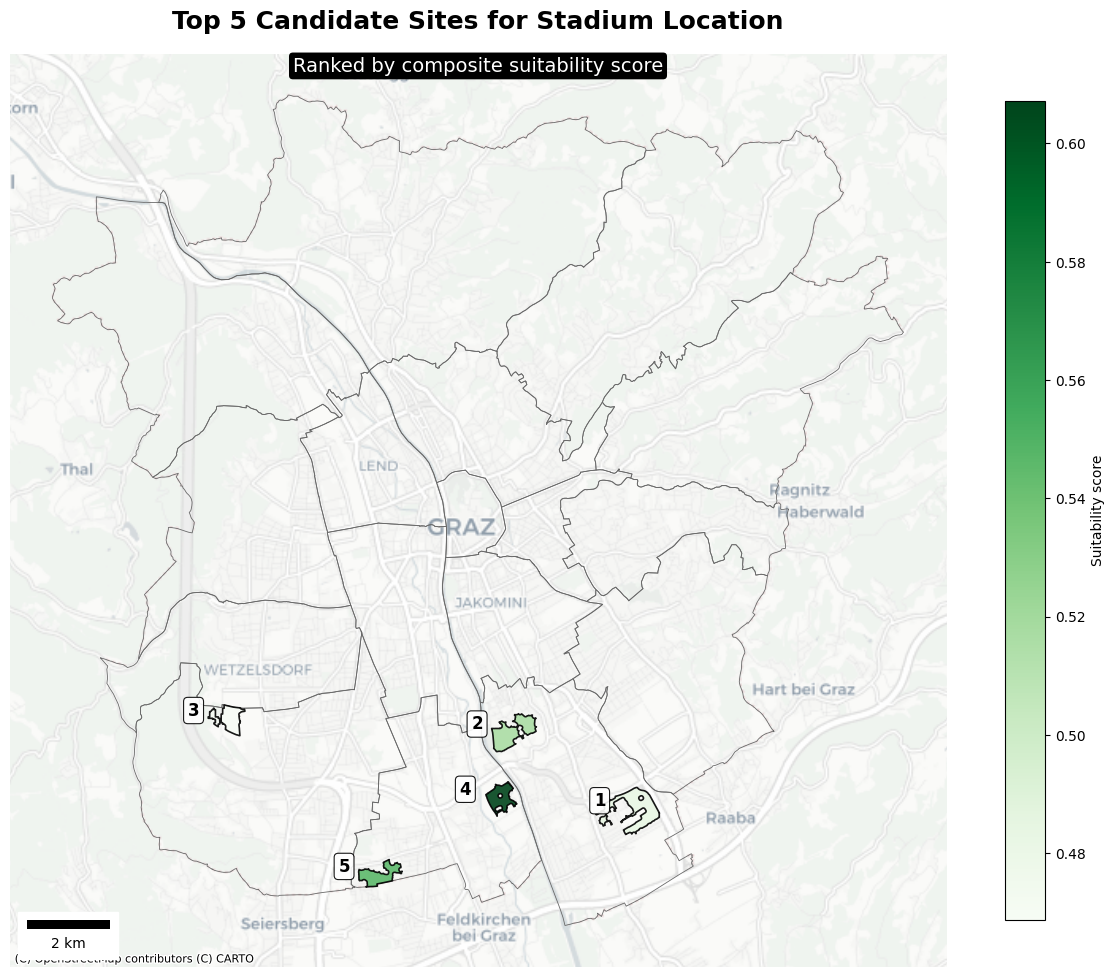

In [48]:
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar

# Prepare data
top5 = gdf_scores.head(5).copy()
top5 = top5.to_crs(epsg=3857)
gdf_districts_web = gdf_districts.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))

# Plot districts
gdf_districts_web.boundary.plot(
    ax=ax,
    color="dimgray",
    linewidth=0.6,
    zorder=1
)

# Plot candidate sites
top5.plot(
    ax=ax,
    column="total_score",
    cmap="Greens",   
    legend=True,
    edgecolor="black",
    linewidth=1.2,
    alpha=0.9,
    zorder=3,
    legend_kwds={
        "label": "Suitability score",
        "shrink": 0.7
    }
)

# Annotate rank (offset to upper-left)
offset_x = -850   # meters (Web Mercator)
offset_y = 200

for rank, (_, row) in enumerate(top5.iterrows(), start=1):
    centroid = row.geometry.centroid
    ax.annotate(
        text=f"{rank}",
        xy=(centroid.x + offset_x, centroid.y + offset_y),
        ha="center",
        va="center",
        fontsize=12,
        fontweight="bold",
        color="black",
        bbox=dict(
            boxstyle="round,pad=0.25",
            fc="white",
            ec="black",
            lw=0.8,
            alpha=0.9
        ),
        zorder=4
    )

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    zoom=12,
    attribution_size=8
)


# Scale bar
scalebar = ScaleBar(
    dx=1,
    units="m",
    location="lower left",
    frameon=True,
    pad=0.6,
    border_pad=0.6
)
ax.add_artist(scalebar)

# Title
ax.set_title(
    "Top 5 Candidate Sites for Stadium Location",
    fontsize=18,
    fontweight="bold",
    pad=18
)

# Subtitle with background box
ax.text(
    0.5, 0.9865,
    "Ranked by composite suitability score",
    transform=ax.transAxes,
    ha="center",
    va="center",
    fontsize=14,
    color="white",
    bbox=dict(
        boxstyle="round,pad=0.2",
        fc="black",
        ec="none",
        alpha=1
    ),
    zorder=5
)



ax.axis("off")
plt.tight_layout()
plt.show()
